# Isolation Forest

In [ ]:
Isolation Forest is an ensemble extremely randomized tree-regressor that uses isolation to separate unusual data points.
Isolation Forest can be used in supervised as well as  unsupervised settings.

In [ ]:
The IsolationForest 'isolates' observations by randomly selecting a feature
    and then randomly selecting a split value between the maximum and minimum
    values of the selected feature.
    Since recursive partitioning can be represented by a tree structure, the
    number of splittings required to isolate a sample is equivalent to the path
    length from the root node to the terminating node.
    This path length, averaged over a forest of such random trees, is a
    measure of normality and our decision function.
    Random partitioning produces noticeably shorter paths for anomalies.
    Hence, when a forest of random trees collectively produce shorter path
    lengths for particular samples, they are highly likely to be anomalies.


In [ ]:
![Isolation Forest](datasets/isolationforest.png)

In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
train_split = 0.80
nrows = 250_000
path = 'c:/users/ugy1/abs/'
df=pd.read_csv(path+'datasets/processed_abs_loan_'+str(nrows)+'.csv', 
               #usecols=use_list, 
               #sep='\t',
               #compression=bz2,
               nrows=nrows,
               low_memory=False, 
              index_col=0, 
               parse_dates=True
              )
df.shape

(237024, 58)

In [3]:
column_list=df.columns.tolist()

In [4]:
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalanceeffectivedate_calc,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,label
0,66711.84,60,3.29,1,808.0,2.90,62677.27,0.0,3.3409,3.3409,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
1,16258.45,60,0.90,0,821.0,4.36,12793.38,0.0,0.9049,0.9049,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
2,31930.41,72,2.90,1,771.0,4.07,26981.85,0.0,2.9430,2.9430,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
3,26065.02,65,0.90,0,890.0,5.00,4907.91,0.0,0.9037,0.9037,...,0.0,1,0,0.0093,0.99,3.86,0.68,0.59,0.92,0
4,42091.00,72,3.90,0,739.0,2.62,37060.44,0.0,3.9676,3.9676,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0


In [5]:
df.label.unique()

array([0, 1], dtype=int64)

In [6]:
df.isnull().sum().any()

False

In [7]:
df.label.replace(1, -1, inplace=True)
df.label.replace(0, 1, inplace=True)

In [8]:
df.label.unique()

array([ 1, -1], dtype=int64)

In [9]:
# prepare label for scikit-learn
Y=df.label.values
Y=Y.reshape(Y.shape[0],1)
Y.shape

(237024, 1)

In [10]:
np.unique(Y)

array([-1,  1], dtype=int64)

In [11]:
# prepare input data for scikit-learn
input=df.values
input.shape

(237024, 58)

In [12]:
# calculate train/test split

len_train = int(len(input)*train_split)
print(len_train)

189619


In [13]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]
x_train = input[0:len_train]
x_test = input[len_train:]
x_train.shape

(189619, 58)

In [14]:
export_x_test = pd.DataFrame(data=x_test)

In [15]:
export_x_test.columns=column_list
export_x_test.rename(columns={'label':'True Label'}, inplace=True)
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalanceeffectivedate_calc,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label
0,36863.24,72.0,1.00,1.0,871.0,2.59,20842.67,0.0,1.0042,1.0042,...,0.0,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,1.0
1,23811.32,60.0,1.90,0.0,845.0,4.12,7241.37,0.0,1.9163,1.9163,...,0.0,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,1.0
2,30669.00,48.0,1.00,1.0,863.0,10.67,21859.06,0.0,1.0055,1.0055,...,0.0,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,1.0
3,54083.21,72.0,1.00,0.0,682.0,4.42,50431.21,0.0,1.0045,1.0045,...,0.0,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,1.0
4,31557.75,72.0,3.89,1.0,761.0,2.56,22262.79,0.0,3.9584,3.9584,...,0.0,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,1.0


In [16]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
#from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

In [17]:
# x_scaler=StandardScaler()
# x_train = x_scaler.fit_transform(x_train)
# x_test = x_scaler.fit_transform(x_test)

In [18]:
x_scaler_train=minmax_scale(x_train, feature_range=(-1, 1))
x_scaler_test=minmax_scale(x_test, feature_range=(-1, 1))

In [19]:
clfIF = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.15, 
                        max_features=1.0, bootstrap=True, n_jobs=-1, random_state=54, verbose=0,
                        #behavior="new"
                       )

In [20]:
clfIF.fit(x_train, y_train)

AttributeError: 'IsolationForest' object has no attribute 'score'

In [21]:
x_pred = x_test

In [22]:
prediction_IF = clfIF.predict(x_pred)
#print(prediction_IF)

In [23]:
np.unique(prediction_IF)

array([-1,  1])

In [24]:
export_x_test['Predicted Label']=prediction_IF

In [25]:
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label,Predicted Label
0,36863.24,72.0,1.00,1.0,871.0,2.59,20842.67,0.0,1.0042,1.0042,...,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,1.0,1
1,23811.32,60.0,1.90,0.0,845.0,4.12,7241.37,0.0,1.9163,1.9163,...,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,1.0,1
2,30669.00,48.0,1.00,1.0,863.0,10.67,21859.06,0.0,1.0055,1.0055,...,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,1.0,1
3,54083.21,72.0,1.00,0.0,682.0,4.42,50431.21,0.0,1.0045,1.0045,...,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,1.0,1
4,31557.75,72.0,3.89,1.0,761.0,2.56,22262.79,0.0,3.9584,3.9584,...,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,1.0,1


In [26]:
export_x_test.shape

(47405, 59)

In [27]:
export_x_test.to_csv(path+"prediction/IF/predicated_IF_abs_loans_"+str(nrows)+".csv", chunksize=10000)

In [28]:
def plot_confusion_matrix(cm, title, classes=['non-Current', 'Current'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [ ]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

             precision    recall  f1-score   support

Non-Current       0.20      0.96      0.33      1467
    Current       1.00      0.88      0.93     45938

avg / total       0.97      0.88      0.91     47405

AUC:  91.8%


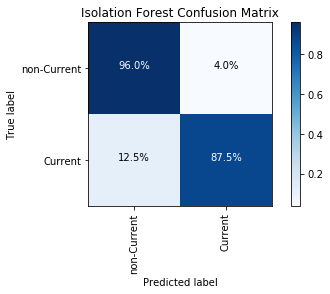

In [29]:
print(classification_report(y_test, prediction_IF, target_names=['Non-Current', 'Current']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, prediction_IF)))
cm = confusion_matrix(y_test, prediction_IF)
plot_confusion_matrix(cm, title="Isolation Forest Confusion Matrix",save=True, 
                      saveas='prediction/IF/cm'+str(' Isolation Forest Accuracy-')+str(nrows)+'.jpg')


ROC_AUC_SCORE ;  0.917799791978
Confusion matrix, without normalization
[[ 1409    58]
 [ 5736 40202]]


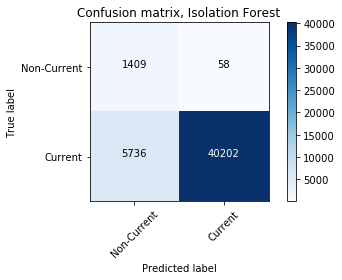

In [30]:
class_names = ['Non-Current', 'Current']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, prediction_IF))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_IF)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title= 'Confusion matrix, Isolation Forest')
plt.savefig('prediction/IF/cm'+str(' Isolation Forest Prediction-')+str(nrows)+'.jpg')
plt.show()